In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import rdkit.Chem as Chem
from rdkit.Chem import Draw
from IPython.display import SVG

In [2]:
BASE = '../'

data = pd.read_csv('../data/molbank/real-acs/acs_test.csv')
pred = pd.read_csv('../output/uspto/swin_base_aux_1m_ep25/prediction_acs_test.csv')

Pred: C([OEt])(C1C=CC=NC=1)=O
Post: CCOC(=O)c1cccnc1


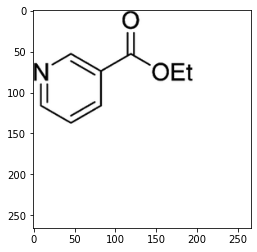

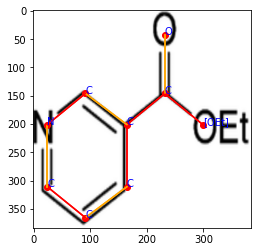

[[0.603, 0.381], [0.778, 0.524], [0.429, 0.524], [0.429, 0.81], [0.238, 0.952], [0.063, 0.81], [0.063, 0.524], [0.238, 0.381], [0.603, 0.111]]
['C', '[OEt]', 'C', 'C', 'C', 'C', 'N', 'C', 'O']
[[0, 1, 1, 0, 0, 0, 0, 0, 2], [1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 0, 0, 2, 0], [0, 0, 1, 0, 2, 0, 0, 0, 0], [0, 0, 0, 2, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 2, 0, 0], [0, 0, 0, 0, 0, 2, 0, 1, 0], [0, 0, 2, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0]]
C([OEt])(C1C=CC=NC=1)=O
smiles: CCOC(=O)c1cccnc1
molblock: 
     RDKit          2D

  9  9  0  0  0  0  0  0  0  0999 V2000
    0.6030    0.6190    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7780    0.4760    0.0000 R   0  0  0  0  0  0  0  0  0  0  0  0
    0.4290    0.4760    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.4290    0.1900    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2380    0.0480    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0630    0.1900    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
 

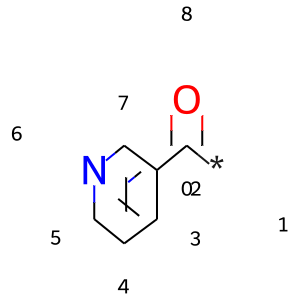

In [22]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300
from bms.chemistry import _verify_chirality, _postprocess_smiles, _replace_functional_group, _convert_graph_to_smiles, canonicalize_smiles
from bms.augment import CropWhite
import albumentations as A

i = 0
pred_row = pred.loc[i]
pred_smiles = pred_row['SMILES']
post_smiles = pred_row['post_SMILES']

print('Pred:', pred_smiles)
print('Post:', post_smiles)

coords = eval(pred_row['node_coords'])
symbols = eval(pred_row['node_symbols'])
edges = eval(pred_row['edges'])


path = '../' + data.loc[i, 'file_path']
img = cv2.imread(path)
plt.imshow(img)
plt.show()

transform = A.Compose([CropWhite(pad=0), A.Resize(384,384)])
img = transform(image=img)['image']
plt.imshow(img)
h,w,_ = img.shape
x, y = np.array(coords)[:,0]*w, np.array(coords)[:,1]*h
plt.scatter(x, y, color='r', marker='o')
for i in range(len(symbols)):
    plt.text(x[i], y[i], symbols[i], color='blue')
for i in range(len(x)):
    for j in range(len(x)):
        if edges[i][j] != 0:
            if edges[i][j] in [5, 6]:
                color = 'blue' if edges[i][j] == 5 else 'green'
                plt.arrow(x[i], y[i], x[j]-x[i], y[j]-y[i], color=color, head_width=20)
            else:
                if edges[i][j] == 1:
                    color = 'red'
                elif edges[i][j] == 2:
                    color = 'orange'
                else:
                    color = 'yellow'
                plt.plot([x[i], x[j]], [y[i], y[j]], color)
plt.show()

print(coords)
print(symbols)
print(edges)

pred_smiles = pred_row['SMILES']
print(pred_smiles, flush=True)
smiles, molblock, _ = _convert_graph_to_smiles(coords, symbols, edges, debug=False)
print('smiles:', smiles)
print('molblock:', molblock)
mol = Chem.MolFromMolBlock(molblock)
mol